# Pipeline for High-z Radio Galaxies 02: AGN/Galaxy classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc, brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
from betacal import BetaCalibration
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

***

## Reading data

We import our data using the `pandas` package.

In [4]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [5]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Z', 'zsp', 'Sint_LOFAR', 'W1mag', 'W2mag', 'spCl', 
                      'num_imputed', 'radio_detect', 'LOFAR_detect', ] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [6]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [7]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [8]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [9]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 141162 elements,
54008 of them are marked as AGN, and 87154 are identified as galaxies.


---

## Possible correlations

In [10]:
print(full_catalog_df.columns.to_list())

['band_num', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

Create target

$0$ for galaxies and $1$ for AGN

In [11]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [12]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str'])

## Split data: Test, Train, Validation

In [13]:
target_feat = 'class'

In [14]:
train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               target_feat, use_calibration=use_calibration)

print('Shape of used data in HETDEX')
print('-' * 60)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 60)
print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (141162, 80)
Data for Modeling (Train, Test, and Calibration): (112929, 80)
Training data:                                    (90343, 80)
Testing data:                                     (11293, 80)
Calibration data:                                 (11293, 80)
Validation data:                                  (28233, 80)
------------------------------------------------------------



Save indices of sources in validation sub-set for future steps.

In [15]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_01.txt', X=val_idx, header='Indices from first AGN training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [16]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [17]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [18]:
rsd_vals

z_y          238.599549
i_z          187.281552
class        127.033401
i_y          124.865561
r_i          110.892108
g_r           98.740411
r_z           89.754088
y_W2          84.285666
r_y           83.458690
g_i           77.469398
g_z           72.835196
g_y           71.104770
z_W2          65.420634
y_W1          65.338144
H_W3          60.724579
z_W1          57.014991
i_W2          54.048779
r_W1          53.500512
i_W1          52.536636
g_W1          51.687513
r_W2          48.610245
J_W3          44.515063
y_J           44.216931
g_W2          44.135429
W1_W3         43.471430
y_H           40.214434
z_J           38.902341
J_H           36.371494
i_J           36.080774
z_H           35.626438
y_K           35.137569
r_J           35.101412
y_W3          34.176725
i_H           33.270322
g_J           33.058355
r_H           32.795280
z_K           31.720826
W2_W3         31.470452
g_H           31.289967
z_W3          30.750167
i_K           30.089862
r_K           29

In [19]:
correlation = norm_train_test_df.corr()

In [20]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [21]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [22]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [23]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [24]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'z_H',
 'J_W1',
 'gmag',
 'J_W2',
 'g_K',
 'rmag',
 'r_K',
 'ymag',
 'imag',
 'y_K',
 'zmag',
 'i_K',
 'z_K',
 'W1mproPM',
 'H_W1',
 'W2mproPM',
 'K_W1',
 'g_W4',
 'H_W2',
 'r_W4',
 'J_W3',
 'K_W2',
 'y_W4',
 'i_W4',
 'z_W4',
 'Jmag',
 'g_W3',
 'J_W4',
 'g_W2',
 'W1_W4',
 'r_W3',
 'y_W3',
 'W2_W4',
 'i_W3',
 'z_W3',
 'W3mag',
 'g_y',
 'r_W2',
 'g_z',
 'i_J',
 'J_K',
 'Kmag',
 'z_J',
 'Hmag',
 'K_W3',
 'g_W1',
 'i_W1',
 'W2_W3',
 'g_J',
 'K_W4',
 'i_W2',
 'H_W4',
 'y_W1',
 'g_i',
 'z_W1',
 'r_y',
 'z_W2',
 'band_num',
 'r_z']

In [25]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [26]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [27]:
corr_discard = norm_train_test_discard.corr()

In [28]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

W4mag  W4mag    1.000000
class  W1_W2    0.861641
r_J    y_J      0.732814
y_J    y_W2     0.715220
r_W1   r_J      0.713003
r_i    r_W1     0.700955
W1_W3  y_J      0.680982
z_y    i_y      0.640374
W1_W2  W1_W3    0.616247
W3_W4  H_W3     0.600178
r_W1   W1_W2    0.591117
W1_W2  g_r      0.564225
g_r    class    0.543138
W1_W3  class    0.539355
i_z    i_y      0.538297
dtype: float64

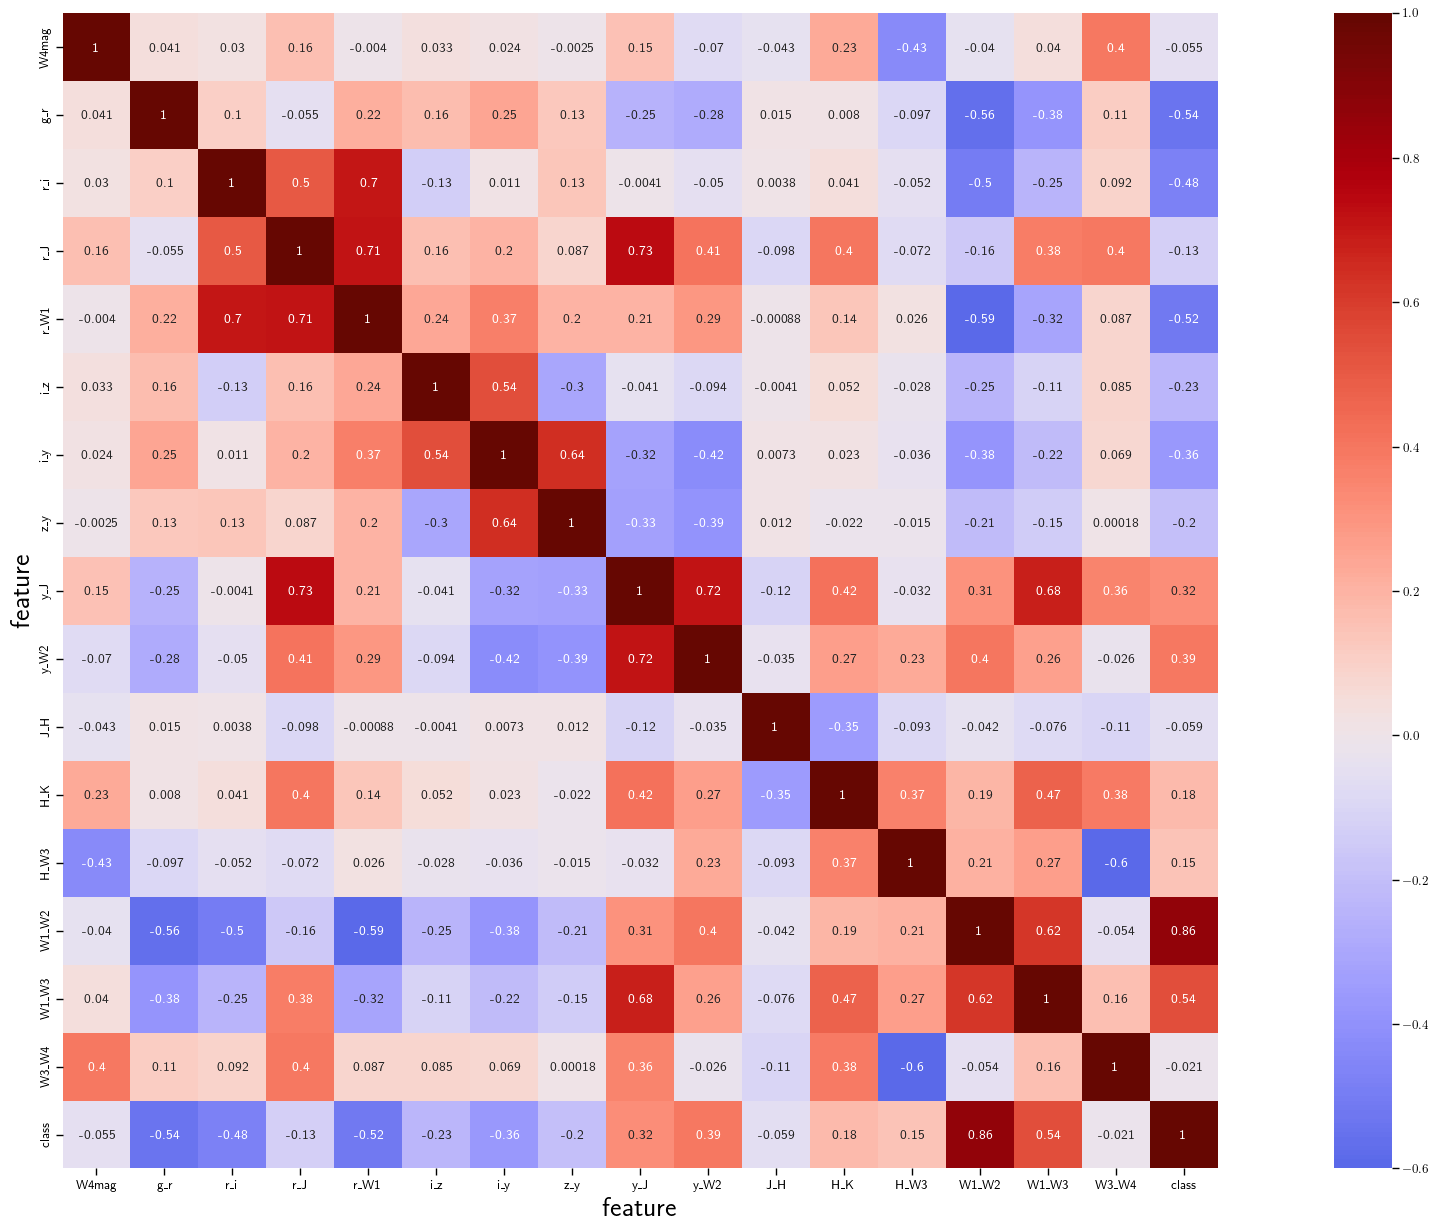

In [29]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')
plt.show()

In [30]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [31]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [32]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x      y    
H_K    H_K      1.000000
W1_W2  class    0.839715
class  W1_W2    0.593176
g_r    class    0.585342
r_i    class    0.521674
H_W3   W3_W4    0.492057
       H_K      0.377210
W1_W3  class    0.374554
J_H    H_K      0.332694
r_i    r_W1     0.287468
       W1_W2    0.280364
g_r    W1_W2    0.279311
class  g_r      0.277139
y_J    r_J      0.269554
r_W1   class    0.263695
i_y    class    0.261005
i_z    class    0.246611
y_W2   class    0.241720
class  r_i      0.239122
H_W3   r_J      0.237632
dtype: float64

In [33]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [34]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [35]:
list_drop_pps = []

In [36]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [37]:
list_drop_pps

[]

In [38]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [39]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=gv.seed)

In [40]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,W1_W2,class,0.839715,classification,True,weighted F1,0.5348,0.925436,DecisionTreeClassifier()
1,g_r,class,0.585342,classification,True,weighted F1,0.5348,0.807101,DecisionTreeClassifier()
2,r_i,class,0.521674,classification,True,weighted F1,0.5348,0.777483,DecisionTreeClassifier()
3,W1_W3,class,0.374554,classification,True,weighted F1,0.5348,0.709042,DecisionTreeClassifier()
4,r_W1,class,0.263695,classification,True,weighted F1,0.5348,0.657471,DecisionTreeClassifier()
5,i_y,class,0.261005,classification,True,weighted F1,0.5348,0.656219,DecisionTreeClassifier()
6,i_z,class,0.246611,classification,True,weighted F1,0.5348,0.649523,DecisionTreeClassifier()
7,y_W2,class,0.241720,classification,True,weighted F1,0.5348,0.647248,DecisionTreeClassifier()
8,y_J,class,0.184933,classification,True,weighted F1,0.5348,0.620831,DecisionTreeClassifier()
9,z_y,class,0.123267,classification,True,weighted F1,0.5348,0.592144,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [41]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [42]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [45]:
exp_AGN = pyc.setup(data                     = train_df,
                    test_data                = test_df,
                    target                   = target_feat,
                    session_id               = gv.seed,
                    silent                   = True,
                    feature_selection        = False,
                    feature_selection_method = 'boruta',
                    data_split_stratify      = True,
                    numeric_features         = final_feats,
                    ignore_features          = feats_2_discard,
                    transformation           = True,
                    transformation_method    = 'yeo-johnson',
                    n_jobs                   = 12,
                    normalize                = True,
                    normalize_method         = 'zscore',
                    use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(90343, 80)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [46]:
pyc.get_config('X').columns

Index(['W4mag', 'g_r', 'r_i', 'r_J', 'r_W1', 'i_z', 'i_y', 'z_y', 'y_J',
       'y_W2', 'J_H', 'H_K', 'H_W3', 'W1_W2', 'W1_W3', 'W3_W4'],
      dtype='object')

In [47]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Add F_beta score ($\beta = 1.1$).

In [48]:
pyc.add_metric('f_beta', 'F_score', gf.f_beta, greater_is_better=True)

Name                                             F_score
Display Name                                     F_score
Score Function       <function f_beta at 0x7fd6629bc280>
Scorer                               make_scorer(f_beta)
Target                                              pred
Args                                                  {}
Greater is Better                                   True
Multiclass                                          True
Custom                                              True
Name: f_beta, dtype: object

In [49]:
metric_to_optimize    = 'Recall'

In [50]:
final_selection_clf   = ['catboost', 'xgboost', 'et', 'rf', 'gbc', 'dummy']  # knn, qda, nb lack feat importances neither coefs, ridge lacks scores
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_to_optimize)  # 1:15 hour for used_models_clf
# top_model_AGN = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_to_optimize)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score,TT (Sec)
catboost,CatBoost Classifier,0.9610,0.9905,0.9450,0.9526,0.9488,0.9173,0.9173,0.9484,3.2100
xgboost,Extreme Gradient Boosting,0.9600,0.9899,0.9441,0.9509,0.9475,0.9151,0.9151,0.9472,9.7640
et,Extra Trees Classifier,0.9590,0.9884,0.9423,0.9502,0.9462,0.9131,0.9132,0.9459,0.4970
rf,Random Forest Classifier,0.9597,0.9886,0.9418,0.9523,0.9470,0.9144,0.9145,0.9465,1.7900
gbc,Gradient Boosting Classifier,0.9567,0.9885,0.9397,0.9468,0.9432,0.9083,0.9083,0.9429,3.3070
dummy,Dummy Classifier,0.6174,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0210


Thus, we select `catboost` as meta learner.

Then, we stack the models.

In [51]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0],\
                                     optimize=metric_to_optimize, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.9608,0.9903,0.9424,0.9546,0.9485,0.9169,0.9169,0.9479
1,0.9634,0.9921,0.9453,0.9584,0.9518,0.9223,0.9223,0.9512
2,0.9589,0.9901,0.9387,0.9533,0.9459,0.9128,0.9129,0.9452
3,0.9625,0.9902,0.9447,0.9566,0.9506,0.9204,0.9204,0.9501
4,0.9614,0.9905,0.9479,0.9509,0.9494,0.9182,0.9182,0.9493
5,0.9597,0.9912,0.9525,0.9427,0.9476,0.9149,0.9149,0.9481
6,0.9580,0.9910,0.9418,0.9482,0.9450,0.9111,0.9111,0.9447
7,0.9587,0.9900,0.9424,0.9493,0.9458,0.9125,0.9125,0.9455
8,0.9592,0.9892,0.9430,0.9499,0.9464,0.9134,0.9134,0.9461


In [52]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping=True, optimize=metric_to_optimize,\
                               search_library='tune-sklearn', search_algorithm='bayesian', choose_better=True)  # 1h15

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.9614,0.9906,0.9430,0.9555,0.9492,0.9180,0.9181,0.9486
1,0.9629,0.9921,0.9442,0.9583,0.9512,0.9213,0.9214,0.9505
2,0.9597,0.9901,0.9407,0.9534,0.9470,0.9145,0.9146,0.9464
3,0.9620,0.9899,0.9453,0.9550,0.9501,0.9195,0.9195,0.9497
4,0.9603,0.9907,0.9444,0.9513,0.9479,0.9158,0.9158,0.9475
5,0.9618,0.9912,0.9497,0.9505,0.9501,0.9191,0.9191,0.9500
6,0.9592,0.9911,0.9456,0.9475,0.9466,0.9135,0.9135,0.9465
7,0.9578,0.9896,0.9427,0.9468,0.9448,0.9107,0.9107,0.9446
8,0.9594,0.9892,0.9442,0.9494,0.9468,0.9139,0.9139,0.9465


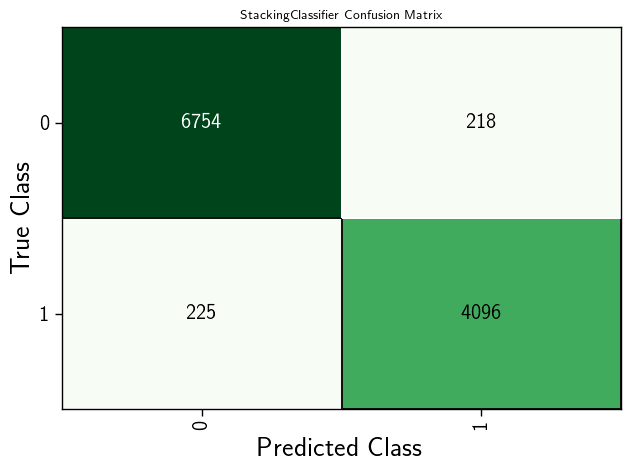

In [53]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

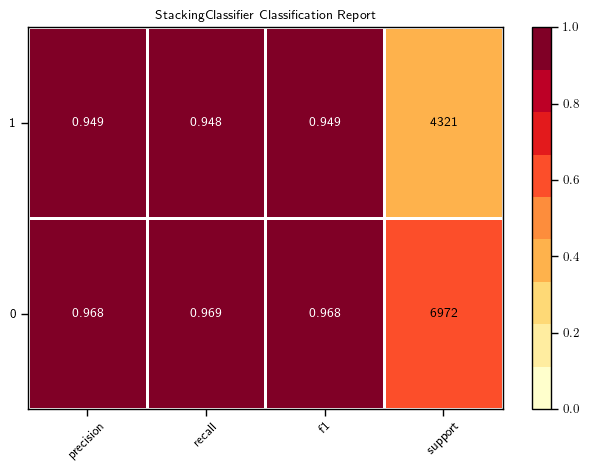

In [54]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

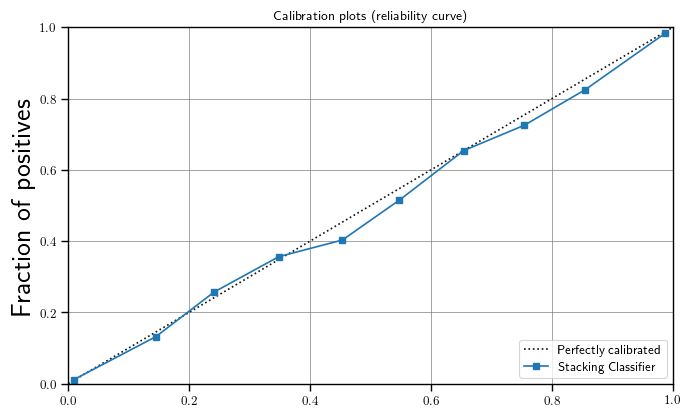

In [55]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

In [60]:
# pyc.plot_model(tuned_AGN_clf.final_estimator_, plot='feature_all')

In [56]:
pyc.plot_model(tuned_AGN_clf.final_estimator_, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,236
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


In [57]:
pyc.plot_model(tuned_AGN_clf.final_estimator, plot='parameter')

,Parameters
depth,3
l2_leaf_reg,11
border_count,254
thread_count,12
verbose,False
random_strength,0.4774801263571897
task_type,CPU
n_estimators,236
random_state,42
eta,0.03463176208525125


In [55]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [56]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9552,0.9865,0.9212,0.9451,0.9330,0.8994,0.8995


,Score_0,Score_1
count,6673.000000,6673.000000
mean,0.663801,0.336199
std,0.438356,0.438356
min,0.000000,0.000100
25%,0.049000,0.005100
50%,0.977600,0.022400
75%,0.994900,0.951000
max,0.999900,1.000000


In [57]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9552,0.9865,0.9212,0.9451,0.9330,0.8994,0.8995


In [ ]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

In [59]:
pyc.predict_model(final_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9552,0.9865,0.9212,0.9451,0.9330,0.8994,0.8995


,Score_0,Score_1
count,6673.000000,6673.000000
mean,0.663801,0.336199
std,0.438356,0.438356
min,0.000000,0.000100
25%,0.049000,0.005100
50%,0.977600,0.022400
75%,0.994900,0.951000
max,0.999900,1.000000


In [61]:
if save_model_flag:
    pyc.save_model(final_AGN_clf, gv.models_path + gv.AGN_gal_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [44]:
if load_model_flag:
    final_AGN_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [45]:
base_models_names = gf.get_base_estimators_names(final_AGN_clf)
base_models       = gf.get_base_estimators_models(final_AGN_clf)

In [46]:
print('Running data pre-processing:\n')
extended_data_AGN_df = gf.preprocess_data(final_AGN_clf, validation_df, base_models_names)

Running data pre-processing:



In [47]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_AGN_clf, extended_data_AGN_df)

In [48]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_AGN_df)

In [49]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [50]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for xgboost...
Calculating for et...
Calculating for rf...
Calculating for gbc...


xgboost                 et                 rf                gbc           
   Feature Importance Feature Importance Feature Importance Feature Importance
0    W1_W2    57.1927   W1_W2    32.6108   W1_W2    29.9299   W1_W2    76.6329
1      r_z    12.7349     g_r     8.6777     g_r    12.8498     r_z    10.0651
2     y_W2     5.5925    y_W2     8.2125     r_z    12.0434    y_W2     4.7362
3    W1_W3     3.3995     g_J     8.1591     r_i    11.9991     g_r     2.9223
4      g_J     2.9464     r_z     7.4874    y_W2     6.6762   W1_W3     1.8102
5    W4mag     2.7532   W1_W3     6.2937    r_W1     5.1253     g_J     1.6908
6      H_K     2.6237    r_W1     6.1333     i_y     4.6890     r_i     0.6459
7      g_r     2.2781     r_i     5.9290     g_J     4.2144   W4mag     0.4462
8     K_W3     2.0387     y_J     4.6867   W1_W3     2.7567    K_W3     0.3524
9      r_i     1.4829     i_y     3.1703     i_z     2.5339     H_K     0.2229
10     y_J     1.3974     i_z     2.3249     y_J     2.3722    r_W1     0.2154
11    r_W1     1.2481     z_y     2.1642     z_y     1.4819     y_J     0.0902
12     i_z     1.1986    K_W3     1.3388     H_K     1.4808     i_z     0.0774
13     i_y     1.1465     H_K     1.1751    K_W3     0.9409     i_y     0.0535
14     z_y     0.9866   W4mag     0.8605     J_H     0.5174     z_y     0.0229
15     J_H     0.9802     J_H     0.7758   W4mag     0.3892     J_H     0.0156

In [51]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,gbc,16.6284
1,rf,9.1364
2,xgboost,9.0573
3,W1_W2,7.1187
4,W1_W3,6.6143
5,et,6.3137
6,g_r,5.6147
7,g_J,4.4730
8,y_W2,4.1218
9,i_y,3.8363


In [52]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False).drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum)

Combined feature importances scaled to sum 100


,Importance
Feature,
W1_W2,29.8351
r_z,8.1227
g_r,8.0288
W1_W3,7.8724
y_W2,6.5444
g_J,5.9212
r_i,5.0962
r_W1,4.5818
i_y,4.5776


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W1_W2	29.835
r_z	8.123
g_r	8.029
W1_W3	7.872
y_W2	6.544
g_J	5.921
r_i	5.096
r_W1	4.582
i_y	4.578
z_y	3.662
i_z	3.526
y_J	3.253
K_W3	2.935
H_K	2.608
J_H	2.263
W4mag	1.173


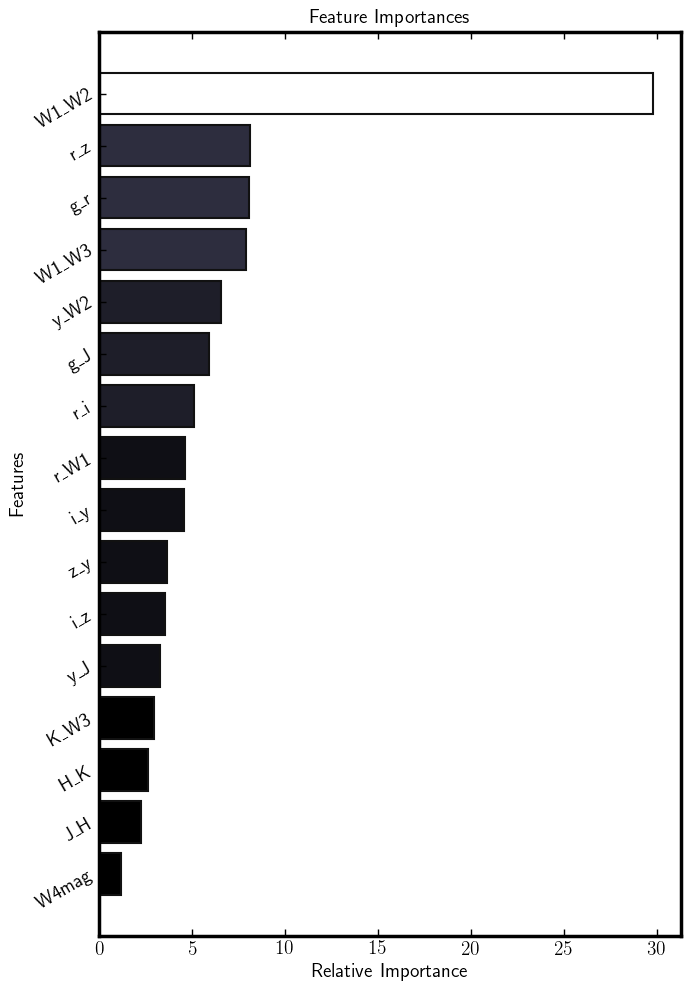

In [53]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_AGN_galaxy_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [54]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_AGN_clf, 'catboost', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,catboost,xgboost,et,rf,gbc
learning_rate,0.0563,0.3000,NaN,NaN,0.1000
depth,6.0000,NaN,NaN,NaN,NaN
random_strength,1.0000,NaN,NaN,NaN,NaN
l2_leaf_reg,3.0000,NaN,NaN,NaN,NaN
n_estimators,NaN,100,100,100,100
subsample,NaN,1.0000,NaN,NaN,1.0000
max_depth,NaN,6.0000,NaN,NaN,3.0000
colsample_bytree,NaN,1.0000,NaN,NaN,NaN
min_child_weight,NaN,1.0000,NaN,NaN,NaN
reg_alpha,NaN,0.0000,NaN,NaN,NaN


---

In [55]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 53,381
Size of test set is  6,673


#### Calculate optimal threshold for classification

In [56]:
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_df,       probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_df,        probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df,  probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_AGN_clf, data=calibration_df, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df,  probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9846574624,0.9985491821,0.9741164759,0.9804609218,0.9772784020,0.9656972126,0.9657088079


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9551925671,0.9864543916,0.9212389381,0.9450748979,0.9330047054,0.8993531540,0.8995187416


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9790189878,0.9967101316,0.9638511570,0.9739348147,0.9688667497,0.9530456839,0.9530750354


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9577401469,0.9881446410,0.9243362832,0.9495454545,0.9367713004,0.9050446119,0.9052293755


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9573192663,0.9888332654,0.9267256637,0.9461510661,0.9363376252,0.9042418277,0.9043518907


#### Naive threshold metrics.

In [57]:
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [58]:
naive_scores_df = gf.create_scores_df([cm_mat_train_naive, cm_mat_test_naive, cm_mat_train_test_naive, cm_mat_calib_naive, cm_mat_val_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [59]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9770,0.9657,0.9805,0.9741
Test,0.9319,0.8995,0.9451,0.9212
Train+Test,0.9684,0.9531,0.9739,0.9639
Calibration,0.9356,0.9052,0.9495,0.9243
Validation,0.9354,0.9044,0.9462,0.9267


#### Calibration curve

In [60]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib, mean_pred_val_calib =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

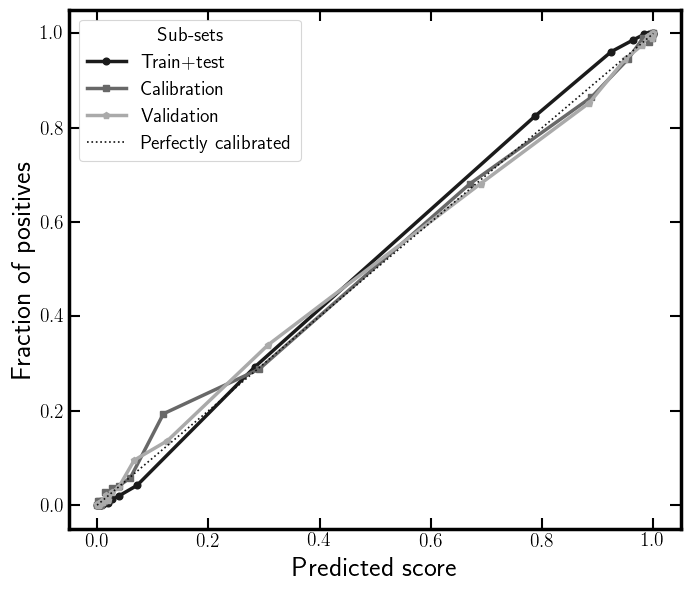

In [61]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib, fract_positiv_calib, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_pre_calib_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()

#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [62]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_calib      = roc_auc_score(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [63]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for calibraton = {roc_auc_calib:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99855
Area under the curve (ROC) for test       = 0.98645
Area under the curve (ROC) for train+test = 0.99671
Area under the curve (ROC) for calibraton = 0.98814
Area under the curve (ROC) for validation = 0.98883


In [64]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_calib,      tpr_calib,      thresh_calib      = roc_curve(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

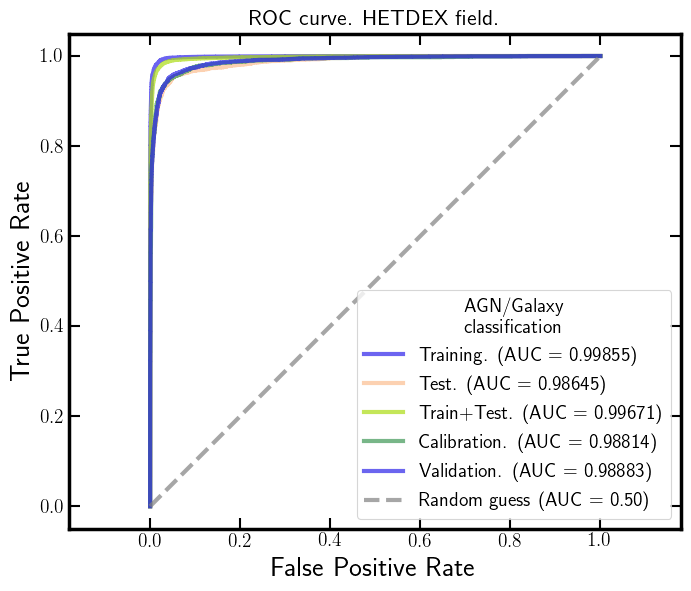

In [65]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_calib       = RocCurveDisplay(fpr=fpr_calib,      tpr=tpr_calib,      roc_auc=roc_auc_calib)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, label=f"Training.    (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, label=f"Test.        (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, label=f"Train+Test.  (AUC = {roc_auc_train_test:0.5f})")
viz_calib.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, label=f"Calibration. (AUC = {roc_auc_calib:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.7, label=f"Validation.  (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

##### Find optimal threshold for each sub-set

In [66]:
opt_t_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_t_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_t_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_t_calib      = thresh_calib[np.argmax(tpr_calib - fpr_calib)]
opt_t_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [67]:
print(f'Optimal threshold from area under the curve (ROC) for training    = {opt_t_train:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for test        = {opt_t_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for train+test  = {opt_t_train_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for calibration = {opt_t_calib:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for validation  = {opt_t_validation:.5f}')

Optimal threshold from area under the curve (ROC) for training    = 0.34572
Optimal threshold from area under the curve (ROC) for test        = 0.22810
Optimal threshold from area under the curve (ROC) for train+test  = 0.32443
Optimal threshold from area under the curve (ROC) for calibration = 0.33162
Optimal threshold from area under the curve (ROC) for validation  = 0.33569


##### Precision-Recall curve

In [68]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_calib,      recall_calib,      thresh_calib      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [69]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_calib      = auc(recall_calib,      prec_calib)
auc_pr_validation = auc(recall_validation, prec_validation)

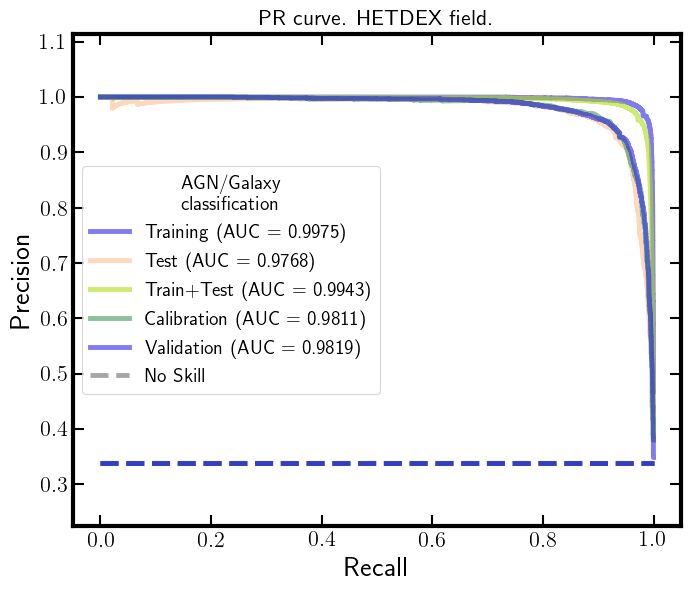

In [70]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib,      recall=recall_calib)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test        (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc='best', fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [71]:
fscore_train      = (1 + gv.beta_F**2) * (prec_train      * recall_train)      / (prec_train * gv.beta_F**2      + recall_train)
fscore_test       = (1 + gv.beta_F**2) * (prec_test       * recall_test)       / (prec_test * gv.beta_F**2       + recall_test)
fscore_train_test = (1 + gv.beta_F**2) * (prec_train_test * recall_train_test) / (prec_train_test * gv.beta_F**2 + recall_train_test)
fscore_calib      = (1 + gv.beta_F**2) * (prec_calib      * recall_calib)      / (prec_calib * gv.beta_F**2      + recall_calib)
fscore_validation = (1 + gv.beta_F**2) * (prec_validation * recall_validation) / (prec_validation * gv.beta_F**2 + recall_validation)

In [72]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_calib      = thresh_calib[np.argmax(fscore_calib)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [73]:
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation:.5f}')

Optimal threshold from Precision-Recall curve for training    = 0.43066
Optimal threshold from Precision-Recall curve for test        = 0.45578
Optimal threshold from Precision-Recall curve for train+test  = 0.43475
Optimal threshold from Precision-Recall curve for calibration = 0.36992
Optimal threshold from Precision-Recall curve for validation  = 0.33569


In [74]:
print(f'The selected threshold, from train+test sub-set is {opt_t_PR_train_test:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_train_test}')

The selected threshold, from train+test sub-set is 0.43475
And, in its complete extension, is 0.4347533096


---

In [75]:
AGN_pred_threshold = float(opt_t_PR_train_test) #  0.43475

In [76]:
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_df,       probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_df,        probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df,  probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_AGN_clf, data=calibration_df, probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df,  probability_threshold=AGN_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9848260617,0.9985491821,0.9776007964,0.9776007964,0.9776007964,0.9661277086,0.9661277086


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9554922823,0.9864543916,0.9269911504,0.9407274360,0.9338087809,0.9002862841,0.9003415447


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9791988251,0.9967101316,0.9678332817,0.9706678500,0.9692484934,0.9535326086,0.9535349362


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9578900045,0.9881446410,0.9305309735,0.9443197126,0.9373746378,0.9056580668,0.9057136571


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9574391560,0.9888332654,0.9322123894,0.9415445120,0.9368552117,0.9047587633,0.9047842922


Create confusion matrices.

In [77]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [78]:
final_scores_df = gf.create_scores_df([cm_mat_train, cm_mat_test, cm_mat_train_test, cm_mat_calib, cm_mat_val],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [79]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(final_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9776,0.9661,0.9776,0.9776
Test,0.9332,0.9003,0.9407,0.9270
Train+Test,0.9691,0.9535,0.9707,0.9678
Calibration,0.9367,0.9057,0.9443,0.9305
Validation,0.9364,0.9048,0.9415,0.9322


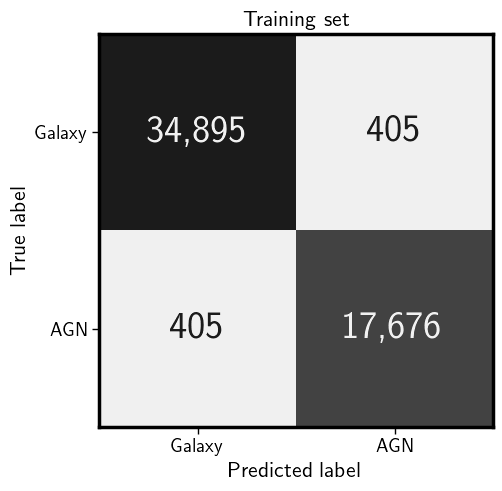

In [80]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

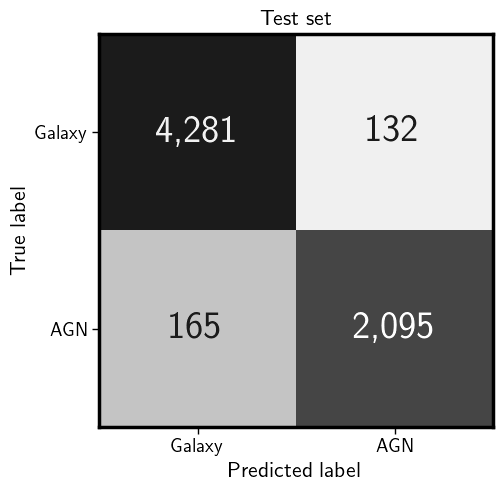

In [81]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

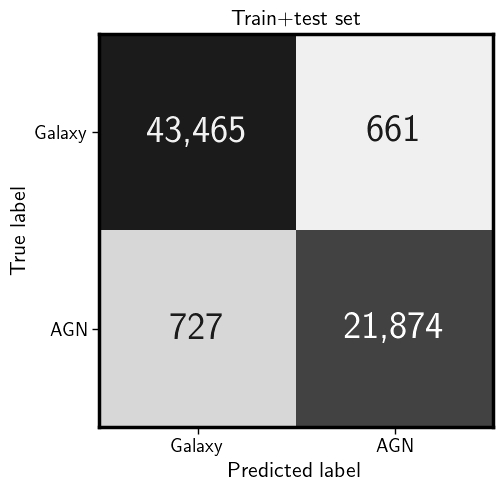

In [82]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

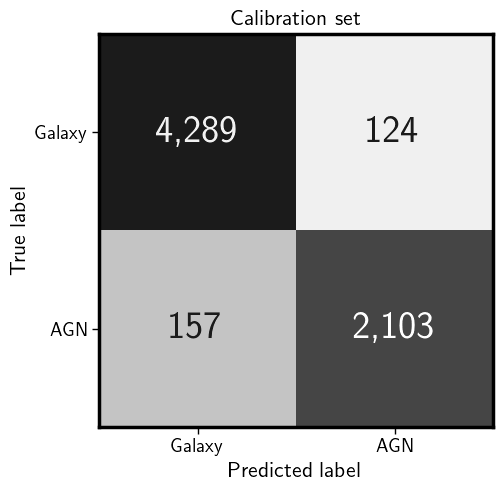

In [83]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_calib, title='Calibration set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

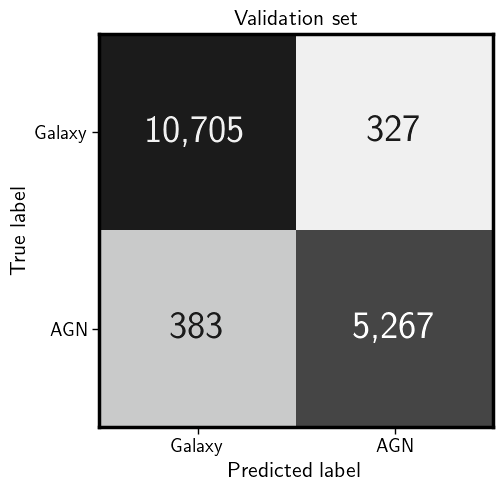

In [84]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [85]:
print('Running data pre-processing for calibration (calibration set):\n')
extended_calibration_df = gf.preprocess_data(final_AGN_clf, calibration_df, base_models_names)
initial_cols            = extended_calibration_df.columns.drop(base_models_names)

Running data pre-processing for calibration (calibration set):



In [86]:
if save_model_flag:
    calibrated_final_AGN_clf = BetaCalibration(parameters='abm')
    calibrated_final_AGN_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
    dump(calibrated_final_AGN_clf, gv.models_path + gv.cal_AGN_gal_model)

In [87]:
if load_model_flag:
    calibrated_final_AGN_clf = load(gv.models_path + gv.cal_AGN_gal_model)

In [88]:
train_prediction_clf['Prob_AGN']      = calibrated_final_AGN_clf.predict(train_prediction_clf.loc[:, 'Score_1'])
test_prediction_clf['Prob_AGN']       = calibrated_final_AGN_clf.predict(test_prediction_clf.loc[:, 'Score_1'])
train_test_prediction_clf['Prob_AGN'] = calibrated_final_AGN_clf.predict(train_test_prediction_clf.loc[:, 'Score_1'])
calib_prediction_clf['Prob_AGN']      = calibrated_final_AGN_clf.predict(calib_prediction_clf.loc[:, 'Score_1'])
validation_prediction_clf['Prob_AGN'] = calibrated_final_AGN_clf.predict(validation_prediction_clf.loc[:, 'Score_1'])

In [89]:
train_prediction_clf['Label_cal_naive']      = np.array(train_prediction_clf.loc[:, 'Prob_AGN']      >= gv.naive_AGN_thresh).astype(int)
test_prediction_clf['Label_cal_naive']       = np.array(test_prediction_clf.loc[:, 'Prob_AGN']       >= gv.naive_AGN_thresh).astype(int)
train_test_prediction_clf['Label_cal_naive'] = np.array(train_test_prediction_clf.loc[:, 'Prob_AGN'] >= gv.naive_AGN_thresh).astype(int)
calib_prediction_clf['Label_cal_naive']      = np.array(calib_prediction_clf.loc[:, 'Prob_AGN']      >= gv.naive_AGN_thresh).astype(int)
validation_prediction_clf['Label_cal_naive'] = np.array(validation_prediction_clf.loc[:, 'Prob_AGN'] >= gv.naive_AGN_thresh).astype(int)

In [90]:
cm_mat_val_cal_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal_naive'])
cm_mat_train_cal_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal_naive'])
cm_mat_test_cal_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal_naive'])
cm_mat_calib_cal_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal_naive'])
cm_mat_train_test_cal_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal_naive'])

In [91]:
scores_cal_naive_df = gf.create_scores_df([cm_mat_train_cal_naive, cm_mat_test_cal_naive,\
                                              cm_mat_train_test_cal_naive, cm_mat_calib_cal_naive, cm_mat_val_cal_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [92]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(scores_cal_naive_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9772,0.9658,0.9791,0.9756
Test,0.9324,0.8999,0.9435,0.9235
Train+Test,0.9687,0.9533,0.9725,0.9656
Calibration,0.9364,0.9060,0.9476,0.9274
Validation,0.9353,0.9037,0.9437,0.9285


##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [93]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Prob_AGN'],      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Prob_AGN'],       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Prob_AGN'], pos_label=1)
prec_calib_cal,      recall_calib_cal,      thresh_calib_cal      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Prob_AGN'],      pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Prob_AGN'], pos_label=1)

AUC for PR curve

In [94]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_calib_cal      = auc(recall_calib_cal,      prec_calib_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

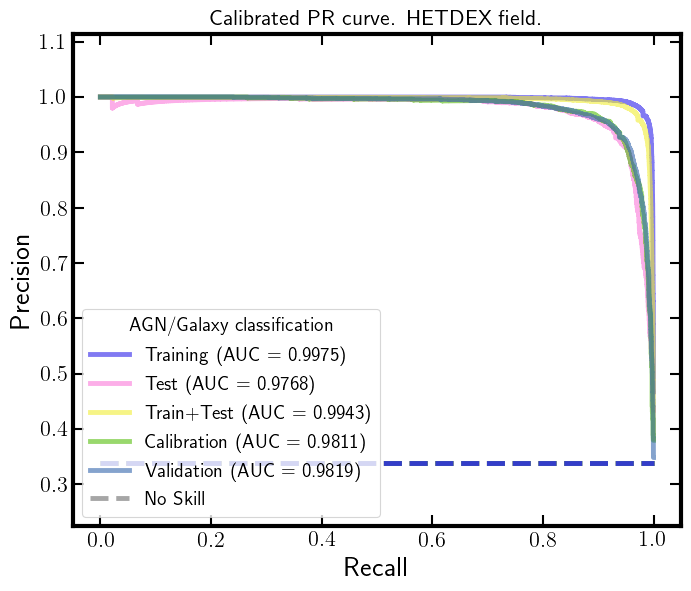

In [95]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib_cal,      recall=recall_calib_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.3), alpha=0.6, label=f"Test        (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.5), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test_cal:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.7), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.9), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='AGN/Galaxy classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [96]:
fscore_train_cal      = (1 + gv.beta_F**2) * (prec_train_cal      * recall_train_cal)      / (prec_train_cal * gv.beta_F**2      + recall_train_cal)
fscore_test_cal       = (1 + gv.beta_F**2) * (prec_test_cal       * recall_test_cal)       / (prec_test_cal * gv.beta_F**2       + recall_test_cal)
fscore_train_test_cal = (1 + gv.beta_F**2) * (prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal * gv.beta_F**2 + recall_train_test_cal)
fscore_calib_cal      = (1 + gv.beta_F**2) * (prec_calib_cal      * recall_calib_cal)      / (prec_calib_cal * gv.beta_F**2      + recall_calib_cal)
fscore_validation_cal = (1 + gv.beta_F**2) * (prec_validation_cal * recall_validation_cal) / (prec_validation_cal * gv.beta_F**2 + recall_validation_cal)

In [97]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_calib_cal      = thresh_calib_cal[np.argmax(fscore_calib_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [98]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training    = 0.45834
Optimal threshold from Precision-Recall curve for test        = 0.48252
Optimal threshold from Precision-Recall curve for train+test  = 0.46230
Optimal threshold from Precision-Recall curve for calibration = 0.39889
Optimal threshold from Precision-Recall curve for validation  = 0.36471


In [99]:
print(f'The selected threshold, from calibration sub-set is {opt_t_PR_calib_cal:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_calib_cal}')

The selected threshold, from calibration sub-set is 0.39889
And, in its complete extension, is 0.39889114096089423


In [100]:
train_prediction_clf['Label_cal']      = np.array(train_prediction_clf.loc[:, 'Prob_AGN']      >= opt_t_PR_calib_cal).astype(int)
test_prediction_clf['Label_cal']       = np.array(test_prediction_clf.loc[:, 'Prob_AGN']       >= opt_t_PR_calib_cal).astype(int)
train_test_prediction_clf['Label_cal'] = np.array(train_test_prediction_clf.loc[:, 'Prob_AGN'] >= opt_t_PR_calib_cal).astype(int)
calib_prediction_clf['Label_cal']      = np.array(calib_prediction_clf.loc[:, 'Prob_AGN']      >= opt_t_PR_calib_cal).astype(int)
validation_prediction_clf['Label_cal'] = np.array(validation_prediction_clf.loc[:, 'Prob_AGN'] >= opt_t_PR_calib_cal).astype(int)

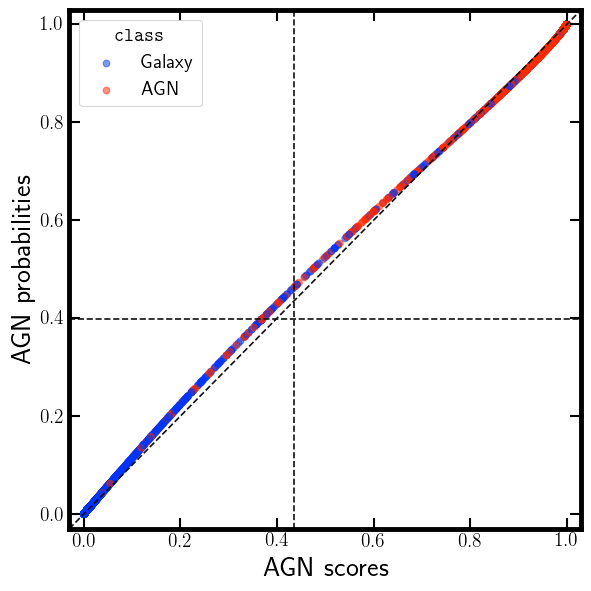

In [101]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

set_to_plot     = calib_prediction_clf

ax1.scatter(set_to_plot.loc[:, 'Score_1'], set_to_plot.loc[:, 'Prob_AGN'], marker='o',\
            alpha=0.5, c=set_to_plot.loc[:, target_feat],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat]))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=opt_t_PR_calib_cal, color='k', ls='dashed')
ax1.axvline(x=opt_t_PR_train_test, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Galaxy',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{class}$', title_fontsize=14)
ax1.set_xlim(left=-0.03, right=1.03)
ax1.set_ylim(bottom=-0.03, top=1.03)
fig.tight_layout()
plt.show()

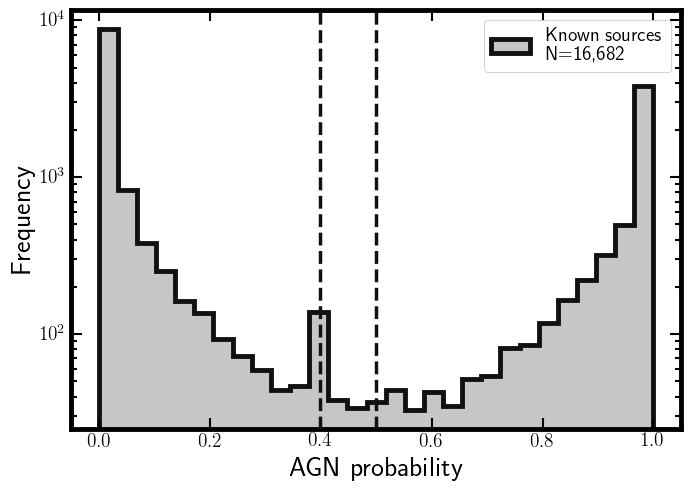

In [102]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

set_to_plot     = validation_prediction_clf

min_score  = np.nanmin(set_to_plot.loc[:, 'Prob_AGN'])
max_score  = np.nanmax(set_to_plot.loc[:, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(set_to_plot.loc[:, 'Prob_AGN'])

ax1.hist(set_to_plot.loc[:, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_calib_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_AGN_cal_probs_validation.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [103]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Prob_AGN'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib_cal, mean_pred_val_calib_cal =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Prob_AGN'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Prob_AGN'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

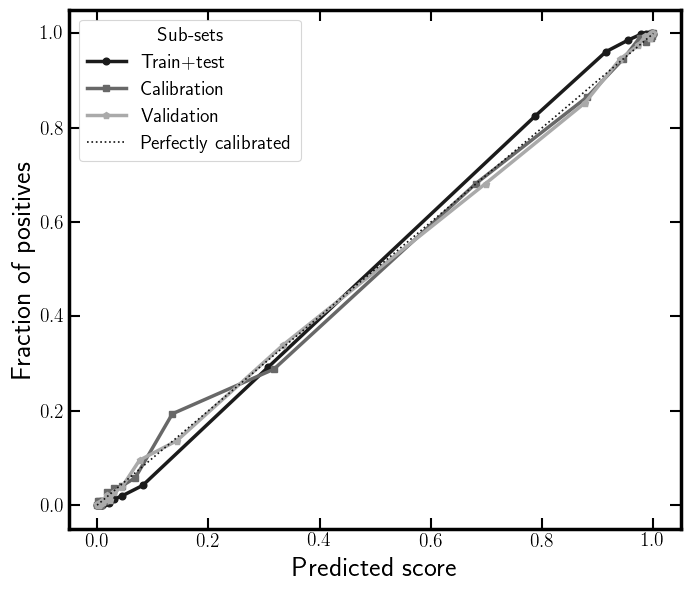

In [104]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib_cal, fract_positiv_calib_cal, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val_cal, fract_positiv_val_cal, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_post_calib_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()

### Check if calibration was useful

Brier score is used for this. And, in particular, Brier Skill Score (BSS).  
Its values can be in the range $[0, 1]$

If BSS $\ll 0$, calibration was not succesful. If BSS $\approx 0$, it performs as the previous model.  
If BSS $\gg 0$, calibration is useful and performs better than original model.

In [105]:
BS_ref = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label'],     pos_label=1)
BS     = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label_cal'], pos_label=1)
BSS    = 1 - (BS/BS_ref)

In [106]:
print(f'Brier Skill Score is {BSS:.3f} using the validation set.')

Brier Skill Score is -0.017 using the validation set.


Create confusion matrices.

In [107]:
cm_mat_train_cal      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal'])
cm_mat_test_cal       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal'])
cm_mat_train_test_cal = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal'])
cm_mat_calib_cal      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal'])
cm_mat_val_cal        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal'])

In [108]:
scores_cal_df = gf.create_scores_df([cm_mat_train_cal, cm_mat_test_cal, cm_mat_train_test_cal, cm_mat_calib_cal, cm_mat_val_cal],\
                                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [109]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(scores_cal_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9775,0.9654,0.9734,0.9809
Test,0.9327,0.8986,0.9343,0.9314
Train+Test,0.9691,0.9527,0.9658,0.9718
Calibration,0.9374,0.9051,0.9356,0.9389
Validation,0.9364,0.9035,0.9344,0.9381


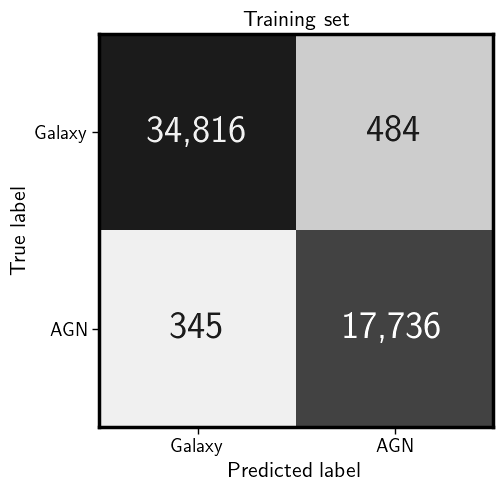

In [110]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_cal, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

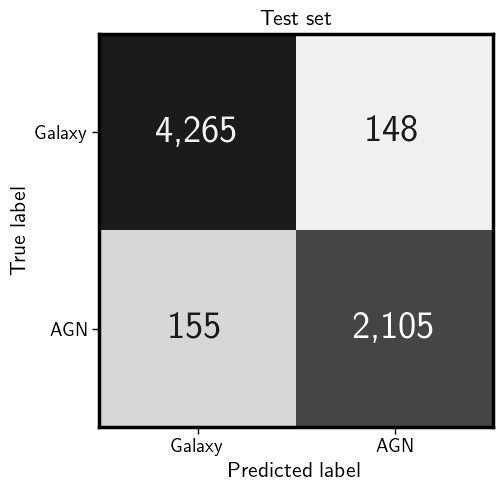

In [111]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_test_cal, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

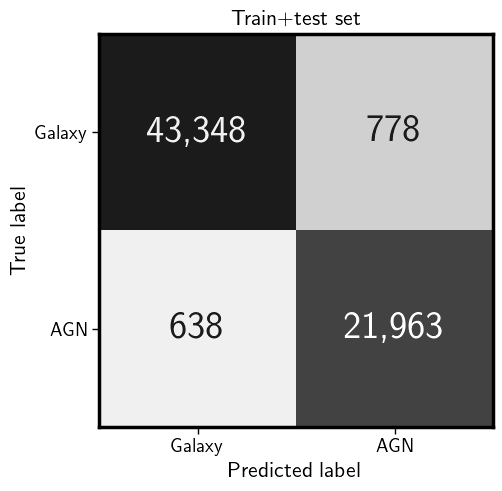

In [112]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_test_cal, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

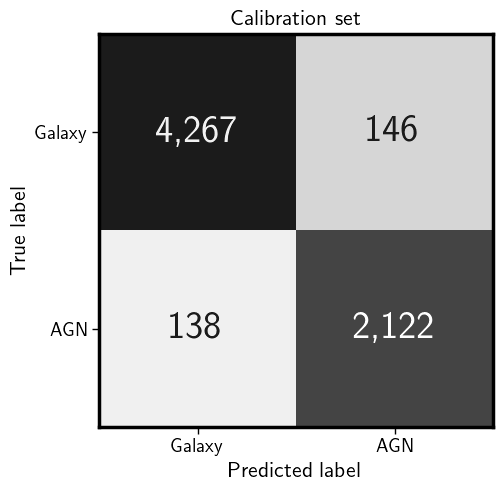

In [113]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_calib_cal, title='Calibration set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

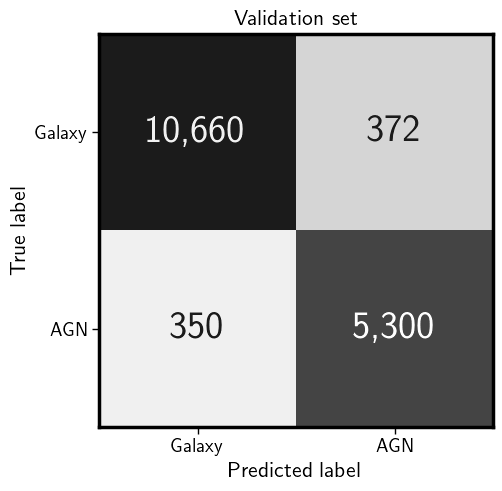

In [114]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_val_cal, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()